# Approximating Pi from Human Trajectories in a Video Game
Approximating pi (~3.14159265358979323846) has been a task of immense interest for humans. There have been many ingenious methods to calculate pi. Here, we explore a new one -- Can we approximate pi from humans trying to move in a circle in a video game?

The answer is of course yes. Where there are circles, there must be Pi. In this work, we build upon one of the earliest methods humans developed to approximate Pi from player trajectories. In ... BC, Archimedes devised a simple method. Archimedes' method

Before going into the details of the methods, we first show the results. The game our human players played in Space Fortress (Mane and Donchin). Still widely used. have been the experimental paradigm for many theories of human decision-making and learning (Anderson...). Recently, thrown as a challenge for reinforcement learning (cite). 

The game controls dictate that the players have to construct the circles, with lines. In other words, they have to approximate circles with polygons. A direct consequence is -- the better the ploygons are as approximations of circles (which simply means higher number of sides in the polygons), the better would be the approximations of Pi according to Archimedes' method to approximate Pi. Another way to look at it: Approximations of Pi provides a measure of performance in moving in cirlces.  [The higher the number of sides, the better the approximations.]

Then, we take a few minutes to marvel at the simple beauty of Archimedes' method and have some fun with it. Combining our knowledge of calculus, we devise a simple way to approximate Pi to many digits using just our computers or, if needed, using a pocket calculator. This exercise is meant mostly for fun, but may come in handy if we find ourselves in need to quickly but accurately approximate Pi in a doomsday situation with aliens invading us and we have no internet. We also discuss why this method worked in approximating Pi from the actions of our human players.

Finally, we present a test bed for the readers, to animate players' trajectories in each game and compare them against the Pi approximations.

In [1]:

# NOTE: Game wise distance, velocity and angular velocity analyzer

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,12)
# sns.set(rc = {'axes.grid':False})
sns.reset_orig()
sns.set(style = 'ticks', font ='serif', font_scale = 1.2)
# sns.set(rc = {'axes.facecolor': 'black', 'figure.facecolor':'black'})
# sns.set_palette("pastel") # options: bright, pastel
sns.color_palette("husl", 9)
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black','figure.edgecolor':'black','axes.grid':False})

# from mpl_toolkits.mplot3d import Axes3D
# plt.rcParams["figure.figsize"] = (12,12)

# import scipy.signal as sg
# from sklearn.preprocessing import StandardScalper, scale
# # from sklearn import cross_validation
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LinearRegression
# from sklearn.cross_decomposition import PLSRegression, PLSSVD
# from sklearn.metrics import mean_squared_error

import copy
import time
# %matplotlib notebook
# from IPython.display import HTML
# plt.rcParams["animation.html"] = "jshtml"


## Functions for Game-wise Plots and Animation

In [2]:


missed_data_list = []

player_list = range(1,10) # range(1,10)
sid_list = [1133, 1639, 1965, 2237, 3154, 3534, 4171, 5754, 6547]
day_list = range(1,32) # range(1,32)
game_list = range(1,9) # range(1,9)

t_old = time.time()

r = 200
x0 = (355-r); y0 = 315
x1 = (355-r/2); y1 = 315 - r*1.125
x2 = (355+r/2); y2 = 315 - r*1.125
x3 = (355+r); y3 = 315
x4 = (355+r/2); y4 = 315 + r*1.125
x5 = (355-r/2); y5 = 315 + r*1.125
points = [(x0, y0), (x1, y1), (x2, y2), (x3, y3), (x4, y4), (x5, y5)]



# f_complete = open('Game_wise_mechanics.csv','w')

# header = ['pid','sid','game','bin_1_0_6','bin_2_6_12','bin_3_12_18','bin_4_18_24','bin_5_24_30','bin_6_30_36','bin_7_36_42','bin_8_42_48',
# 'bin_9_48_54','bin_10_54_60','bin_11_59_65','bin_12_66_72','bin_13_72_78','bin_14_78_84','bin_15_83_89','bin_16_90_96',
# 'bin_17_96_102','bin_18_102_108','bin_19_107_113','bin_20_114_120','bin_21_120_126','bin_22_125_131','bin_23_132_138',
# 'bin_24_138_144','bin_25_144_150','bin_26_150_156','bin_27_156_162','bin_28_162_168','bin_29_168_174','bin_30_173_179',
# 'bin_31_180_186','bin_32_186_192','bin_33_192_198','bin_34_198_204','bin_35_204_210','bin_36_210_216','bin_37_215_221',
# 'bin_38_221_227','bin_39_228_234','bin_40_234_240','bin_41_240_246','bin_42_246_252','bin_43_252_258','bin_44_257_263',
# 'bin_45_264_270','bin_46_270_276','bin_47_276_282','bin_48_282_288','bin_49_288_294','bin_50_294_300','bin_51_300_306',
# 'bin_52_306_312','bin_53_312_318','bin_54_318_324','bin_55_324_330','bin_56_330_336','bin_57_336_342','bin_58_342_348',
# 'bin_59_348_354','bin_60_353_359','bin_61_359_365','bin_62_366_372','bin_63_372_378','bin_64_378_384','bin_65_384_390',
# 'bin_66_390_396','bin_67_395_401','bin_68_402_408','bin_69_407_413','bin_70_414_420','bin_71_420_426','bin_72_426_432',
# 'bin_73_432_438','bin_74_437_443','bin_75_444_450','bin_76_449_455','bin_77_456_462','bin_78_462_468','bin_79_468_474',
# 'bin_80_474_480','bin_81_479_485','bin_82_486_492','bin_83_491_497','bin_84_498_504','bin_85_503_509','bin_86_510_516',
# 'bin_87_516_522','bin_88_521_527','bin_89_528_534','bin_90_534_540','bin_91_540_546','bin_92_546_552','bin_93_552_558',
# 'bin_94_558_564','bin_95_564_570','bin_96_570_576','bin_97_575_581','bin_98_582_588','bin_99_588_594','bin_100_594_600',
# 'mean_vel','sd_vel','max_vel','min_vel']

# s = ",".join(map(str,header)) +'\n'

# f_complete.write(s)

# compilation = pd.DataFrame(columns = ['markers_ship_hit','markers_ship_des ','markers_100','markers_200','markers_shot_zero',
# 	'markers_double_shot_zero ','markers_friend_killed','markers_foe_killed', 'markers_warp','markers_bump'])

error_list = []
ultimate_max = 0

game_start, game_end = [0, 248]
game_interval = game_end - game_start
i_game = 0

loc_angle = np.zeros([game_interval, 10])
loc_r = np.zeros([game_interval, 10])
vel_angle = np.zeros([game_interval, 10])
vel_r = np.zeros([game_interval, 10])

omega = np.zeros([game_interval, 10]) # vel_r / loc _r

def exhibit(list_pg): # Exhibits location information for player number and day and game number 
	fig = plt.figure()
	n_pg = len(list_pg)
	col_n = n_pg; ax = ['']*(col_n+1)
	ax[0] = fig.add_subplot(100+10*(col_n)+(0+1)) 
	ax[1:col_n] = [fig.add_subplot(100+10*(col_n)+(col_i+1), sharey = ax[0]) for col_i in range(1,col_n)]
	for i_pg in range(n_pg):
		player,agame = list_pg[i_pg]
		game = agame%8
		if game == 0: game = 8; day = np.ceil(agame/8.) 
		else: day = np.ceil(agame/8.)
		print(day, game)

		try:
			sid = sid_list[player-1]
			p_data = pd.read_csv("Compiled_by_Roussel_all\\%i\\p%i_%i-%i-%i.csv" %(player, player, sid, day, game))	
			p_data.ship_x = pd.to_numeric(p_data.ship_x, errors = 'coerce')
			p_data.ship_y = pd.to_numeric(p_data.ship_y, errors = 'coerce')
			p_data.ship_vel_x = pd.to_numeric(p_data.ship_vel_x, errors = 'coerce')
			p_data.ship_vel_y = pd.to_numeric(p_data.ship_vel_y, errors = 'coerce')

			xx_loc_r = np.sqrt((p_data.ship_x)**2 + (p_data.ship_y)**2 )
			m = np.floor((p_data.game_time- p_data.game_time[0])/1000.) # To get the timestamps at each second
			xx_loc_r = xx_loc_r.loc[m != m.shift()] 								# Get the corresponding distances at each second
			xx_loc_r = xx_loc_r[~np.isnan(xx_loc_r)]	

			xx_vel_r = np.sqrt((p_data.ship_vel_x)**2 + (p_data.ship_vel_y)**2 )
			m = np.floor((p_data.game_time- p_data.game_time[0])/1000.) # To get the timestamps at each second
			xx_vel_r = xx_vel_r.loc[m != m.shift()] 								# Get the corresponding distances at each second
			xx_vel_r = xx_vel_r[~np.isnan(xx_vel_r)]										# Remove nan values

			xx_loc_angle = np.arctan(p_data.ship_y / p_data.ship_x)
			m = np.floor((p_data.game_time- p_data.game_time[0])/1000.) # To get the timestamps at each second
			xx_loc_angle = xx_loc_angle.loc[m != m.shift()] 								# Get the corresponding distances at each second
			xx_loc_angle = xx_loc_angle[~np.isnan(xx_loc_angle)]										# Remove nan values

			xx_vel_angle = np.arctan(p_data.ship_vel_y / p_data.ship_vel_x)
			m = np.floor((p_data.game_time- p_data.game_time[0])/1000.) # To get the timestamps at each second
			xx_vel_angle = xx_vel_angle.loc[m != m.shift()] 								# Get the corresponding distances at each second
			xx_vel_angle = xx_vel_angle[~np.isnan(xx_vel_angle)]										# Remove nan values

			xx_omega = xx_vel_r / xx_loc_r

			# loc_angle[i_game, player] = np.mean(xx_loc_angle)
			# loc_r[i_game, player] = np.mean(xx_loc_r)
			# vel_angle[i_game, player] = np.mean(xx_vel_angle)
			# vel_r[i_game, player] = np.mean(xx_vel_r)
			# omega[i_game, player] = np.mean(xx_omega)
			X = xx_loc_r*np.cos(xx_loc_angle)
			Y = xx_loc_r*np.sin(xx_loc_angle)
			# print len(X),'\n',X

			U_theta = xx_vel_r*np.cos(xx_loc_angle)
			V_theta = xx_vel_r*np.sin(xx_loc_angle)

			U_alpha = xx_vel_r*np.cos(xx_vel_angle)
			V_alpha = xx_vel_r*np.sin(xx_vel_angle)



			ax[i_pg].plot(X, Y, label = 'Positions', color = 'red', marker = '.', linestyle = '--')
			ax[i_pg].quiver(X, Y, U_theta, V_theta, label = 'Theta', color = 'blue')
			ax[i_pg].quiver(X, Y, U_alpha, V_alpha, label = 'Alpha')
		except IOError:
			print('error: no file found for:', player, day, game)
	plt.legend()
	plt.show()

def anim(player): # 	# Animates match-wise .... for a given player, not complete
	sid = sid_list[player-1]
	fig = plt.figure()
	# ax = fig.add_subplot(111, aspect = 'equal', autoscale_on = True)
	# time_text = ax.text(.5, 0.7, '', transform = ax.transAxes,color='white')
	# # grids=ax.grid()

	# plt.xticks(np.arange(1.,11.1))
	# plt.yticks(np.arange(1.,21.1))
	# plt.grid(True,color='white',ls='solid')

	# cmap = matplotlib.colors.ListedColormap(['black','red'])

	# match_data = np.zeros(248)

	# for ov_game_number in range(1, 248):
	# 	day = np.ceil(ov_game_number/8.)
	# 	game = ov_game_number - (day-1)*8
	# 	p_data = pd.read_csv("Compiled_by_Roussel_all\\%i\\p%i_%i-%i-%i.csv" %(player, player, sid, day, game))	
	# 	p_data.ship_x = pd.to_numeric(p_data.ship_x, errors = 'coerce')
	# 	p_data.ship_y = pd.to_numeric(p_data.ship_y, errors = 'coerce')
	# 	p_data.ship_vel_x = pd.to_numeric(p_data.ship_vel_x, errors = 'coerce')
	# 	p_data.ship_vel_y = pd.to_numeric(p_data.ship_vel_y, errors = 'coerce')

	# 	xx_loc_r = np.sqrt((p_data.ship_x)**2 + (p_data.ship_y)**2 )
	# 	m = np.floor((p_data.game_time- p_data.game_time[0])/1000.) # To get the timestamps at each second
	# 	xx_loc_r = xx_loc_r.loc[m != m.shift()] 								# Get the corresponding distances at each second
	# 	xx_loc_r = xx_loc_r[~np.isnan(xx_loc_r)]	

	# 	xx_vel_r = np.sqrt((p_data.ship_vel_x)**2 + (p_data.ship_vel_y)**2 )
	# 	m = np.floor((p_data.game_time- p_data.game_time[0])/1000.) # To get the timestamps at each second
	# 	xx_vel_r = xx_vel_r.loc[m != m.shift()] 								# Get the corresponding distances at each second
	# 	xx_vel_r = xx_vel_r[~np.isnan(xx_vel_r)]										# Remove nan values

	# 	xx_loc_angle = np.arctan(p_data.ship_y / p_data.ship_x)
	# 	m = np.floor((p_data.game_time- p_data.game_time[0])/1000.) # To get the timestamps at each second
	# 	xx_loc_angle = xx_loc_angle.loc[m != m.shift()] 								# Get the corresponding distances at each second
	# 	xx_loc_angle = xx_loc_angle[~np.isnan(xx_loc_angle)]										# Remove nan values

	# 	xx_vel_angle = np.arctan(p_data.ship_vel_y / p_data.ship_vel_x)
	# 	m = np.floor((p_data.game_time- p_data.game_time[0])/1000.) # To get the timestamps at each second
	# 	xx_vel_angle = xx_vel_angle.loc[m != m.shift()] 								# Get the corresponding distances at each second
	# 	xx_vel_angle = xx_vel_angle[~np.isnan(xx_vel_angle)]										# Remove nan values

	# 	xx_omega = xx_vel_r / xx_loc_r

	# 	# loc_angle[i_game, player] = np.mean(xx_loc_angle)
	# 	# loc_r[i_game, player] = np.mean(xx_loc_r)
	# 	# vel_angle[i_game, player] = np.mean(xx_vel_angle)
	# 	# vel_r[i_game, player] = np.mean(xx_vel_r)
	# 	# omega[i_game, player] = np.mean(xx_omega)
	# 	X = xx_loc_r*np.cos(xx_loc_angle)
	# 	Y = xx_loc_r*np.sin(xx_loc_angle)

	# 	U_theta = xx_vel_r*np.cos(xx_loc_angle)
	# 	V_theta = xx_vel_r*np.sin(xx_loc_angle)

	# 	U_alpha = xx_vel_r*np.cos(xx_vel_angle)
	# 	V_alpha = xx_vel_r*np.sin(xx_vel_angle)



	# 	# ax[i_pdg].plot(X, Y, label = 'Positions', color = 'red', marker = '.', linestyle = '--')
	# 	# ax[i_pdg].quiver(X, Y, U_theta, V_theta, label = 'Theta', color = 'blue')
	# 	# ax[i_pdg].quiver(X, Y, U_alpha, V_alpha, label = 'Alpha')

	# fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[3, 1]})

	fig, ax0 = plt.subplots(1,1)

	ax0.axis('equal')
	ax0.set_facecolor('black')
	ax0.plot(*zip(*(points+points[:1])), color = 'green', marker='o', lw = 4)
	ax0.plot(355,315,'r+', markersize = 10, label = 'Fortress', markeredgewidth = 2)
	ax0.set_xlim([0,710]); ax0.set_ylim([0,630])
	ax0.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False)
	ax0.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)

	next_zoid_text = ax0.text(1, 2, '',color='black', fontsize = 12)

	def animate_main(ov_game_number):
		day = np.ceil(ov_game_number/8.)
		game = ov_game_number - (day-1)*8
		p_data = pd.read_csv("Compiled_by_Roussel_all\\%i\\p%i_%i-%i-%i.csv" %(player, player, sid, day, game))	
		X = pd.to_numeric(p_data.ship_x, errors = 'coerce')
		Y = pd.to_numeric(p_data.ship_y, errors = 'coerce')
		xx= ax0.plot(X, Y, 'b.')
		# next_zoid_text.set_text('Game number: %i' %ov_game_number)
		# print ov_game_number
		return xx

	# def animate_text(i):
	# 	ax1.set_xlim([0.,4.]); ax1.set_ylim([0.,3])
	# 	next_zoid_text.set_text('Game number: %i' %i)
	# 	return next_zoid_text,

	ani_main = animation.FuncAnimation(fig, animate_main, np.arange(1,248),
	                       interval = 50, blit = True, repeat = False)
	# ani_text = animation.FuncAnimation(fig, animate_text, np.arange(1,248),
 #                           interval = 50, blit = True, repeat = False)

	# plt.grid(True,color='white',ls='solid')
	# ani_main.save('test.mpg', dpi=300, writer='imagemagick')
	return(ani_main)
	plt.show()
	plt.close()
# # --------------------------------------------Animation Function ends

## Approximating Pi + Calculting Instantaneous Angular Velocity

We will use the (x,y) coordinates against time in these calculations. First, we will get the information into some convenient forms. Second, we estimate Pi values and third, we get the angular velocity.

### Approximating Pi

We calculate Pi for each circle completed around the Fortress. So the Fortress is the center of every circle. To get Pi, we want to use the relationship perimeter S = $2\pi*r \Rightarrow \pi = \frac{S}{2r}$

The distance traveled by the ship in each circle is the "s" or the perimeter of the polygon/circle. For "r", we use the average distance of the ship from the Fortress.

In [98]:

# Euclidean distance between two points
def eu_distance(x1, y1, x2, y2):
	d = np.sqrt((x1-x2)**2 + (y1-y2)**2)
	return(d)

# Convert polar co-ordinates to complex numbers of form z = r*e^\theta
def polar2z(r,theta):
    return r * np.exp( 1j * theta )

# Version 1: Convert complex numbers of form z = r*e^\theta to z = (r, theta)
	# using defaults for angle, returns angle between -pi to pi or -180 to 180
def z2polar1(z):
    return ( np.abs(z), np.angle(z) )

# Version 2: Convert complex numbers of form z = r*e^\theta to z = (r, theta)
	# with my tweaks, returns angle between 0 to 2*pi or 0 to 360
def z2polar2(z): 
    angles = np.angle(z) # default return within -pi to pi
    # here, we implement an if condition: if the angle is negative, add 2pi with the angle
    angles[angles<0] = angles[angles<0] + 2*np.pi
    return ( np.abs(z),  angles)

convert_radtodeg = 180/np.pi
fortress_x = 355
fortress_y = 315

pi_all = []
pi_per_game = np.zeros([248,1])
mean_r_per_game = np.zeros([248,1])
total_d_per_game = np.zeros([248,1])

# ov_game_number = 10
game_list = np.arange(9,249) # [20, 120, 220] # Manual changes here!

new_run = 1

if (new_run):

# ------------------- LOAD DATA -----------------------------
# Loading the agg data from 2019-2020.
# We also load the old complete file with aggregated data to add more information to it.

	agg_df = pd.read_csv("Complete_18Apr.csv")

	agg_df["X_arr"] = 0
	agg_df["Y_arr"] = 0
	agg_df["total_d_per_cycle"] = 0
	agg_df["mean_r_per_cycle"] = 0
	agg_df["pi_per_cycle"] = 0

	agg_df.X_arr = agg_df.X_arr.astype(object)
	agg_df.Y_arr = agg_df.Y_arr.astype(object)
	agg_df.total_d_per_cycle = agg_df.total_d_per_cycle.astype(object)
	agg_df.mean_r_per_cycle = agg_df.mean_r_per_cycle.astype(object)
	agg_df.pi_per_cycle = agg_df.pi_per_cycle.astype(object)
	# print(agg_df.pi_cycle)


	# -------------- Calculate Pi per cycle around the Fortress -------------------

	# Later we will average them over cycles to get game-wise approximations of Pi
	num_players = 9

	for player in range(1, num_players + 1):
		# player_df = pd.DataFrame(np.zeros([game_list.shape[0], 5]), 
		# 					  columns = ["pid", "game_number", "mean_r_cycle", "total_distance_cycle", "pi_cycle"])
		# player_df["game_number"] = game_list
		# player_df.pi_cycle = player_df.pi_cycle.astype(object)
		# print(player_df.pi_cycle.astype(object))
		# print(player_df.pi_cycle)
		sid = sid_list[player-1]

		# I used sample count to plot angular velocities longitudinally for all games to be shown.(?)
		sample_count = 0

		colors = ['red', 'blue','green']
		game_i = 0

		for ov_game_number in game_list:
			if ((player == 4) & (ov_game_number in [57, 59, 116, 118, 215])): # Missing data for P4
				pi_per_game[ov_game_number] = np.nan
				continue 
			print(player, ov_game_number)
			day = np.ceil(ov_game_number/8.)
			game = ov_game_number - (day-1)*8
			
			p_data = pd.read_csv("Compiled_by_Roussel_all\\%i\\p%i_%i-%i-%i.csv" %(player, player, sid, day, game))
			X = pd.to_numeric(p_data.ship_x, errors = 'coerce')
			Y = pd.to_numeric(p_data.ship_y, errors = 'coerce')

			# We translate our frame of reference to have Fortress at the origin (x = 0, y = 0)
			x = X - 355 # x,y: Player locations WRT FORTRESS
			y = Y - 315

			# Now we have the ship's coordinates in cartesian form.
			# It may help to have it in (a) polar and (b) complex number form
			# Expecially as we deal with the angle changes to estimate angular velocity
			r, theta = z2polar2(x+1j*y)


	# ---------------------------- Calculcting Pi PER CYCLE ---------------------------------------------------

			# # We get the cycle breaks by using the criterion: y turns positive->negative
			# # Which translates to: (y.shift())&(y<0)
			# interpretation: We are using the y = 0 line as the divider, from one particular direction.

			cycle_breaks = np.where((y<0) & (y.shift() >0))[0]
			num_cycles = cycle_breaks.shape[0]
			total_d_cycle = np.zeros([num_cycles,1])
			mean_r_cycle = np.zeros([num_cycles,1])
			pi_cycle = np.zeros([num_cycles,1])

			cycle_start_i = 0
			cycle_end_i = 0

			for cy_break_i in np.arange(num_cycles):
				cycle_end_i = cycle_breaks[cy_break_i]
				x_cycle = x[cycle_start_i:cycle_end_i]
				y_cycle = y[cycle_start_i:cycle_end_i]
				a = x_cycle
				b = y_cycle # ??
				d_cycle = np.sqrt((a - a.shift())**2+(b - b.shift())**2)
				total_d_cycle[cy_break_i] = np.nansum(d_cycle)
				mean_r_cycle[cy_break_i] = np.mean(np.sqrt(a**2+b**2))
				pi_cycle[cy_break_i] = total_d_cycle[cy_break_i]/2/mean_r_cycle[cy_break_i]  # ***************************************
				# print(total_d_cycle[cy_break_i], mean_r_cycle[cy_break_i], pi_cycle[cy_break_i])
				pi_all.append(pi_cycle[cy_break_i])
				cycle_start_i = cycle_end_i
			# print(pi_cycle)

			# Store data in agg_df
				# First, we locate the row index in df. Easiest way, it seemed.
			index_in_agg_df = agg_df.loc[(agg_df["pid"] == player) & (agg_df["game"] == ov_game_number)].index[0]
				# Then, assign each value to right column
			# print(mean_r_cycle.shape, np.array(x).reshape(-1,1).shape)
			agg_df.loc[index_in_agg_df, "X_arr"] = np.array(x).reshape(-1,1) # Needed to reshape, otherwise was giving a stupid error.
			agg_df.loc[index_in_agg_df, "Y_arr"] = np.array(y).reshape(-1,1)
			agg_df.loc[index_in_agg_df, "mean_r_per_cycle"] = mean_r_cycle
			agg_df.loc[index_in_agg_df, "total_d_per_cycle"] = total_d_cycle
			agg_df.loc[index_in_agg_df, "pi_per_cycle"] = pi_cycle
	# # ---------------------------- PER GAME (FROM CYCLES) ---------------------------------------------------
			# pi_per_game[ov_game_number-1] = np.mean(pi_cycle)   # ***************************************
		
		# pdf[player-1] = player_df
		# np.savetxt("pi_per_game_datafiles//pi_per_game_player_%i.txt"%player, pi_per_game)

	# ---------------------- Instantaneous Angular Velocity ----------------------------------------

			continue
			p_data['ship_r_wf'] = r
			p_data['ship_theta_wf'] = theta

			angular_velocity = p_data.ship_theta_wf.diff()/33.*1000. # 33 ms is the time interval
			# multiplied by 1000 to get in rad/second unit, instead of rad/milisecond


			# How to fix errors from 0 <--> 360 angle differences? mistakes
				# It's not an error, per se. As we cross the reference line, we need to correct the angles to get the actual angle change.
				# It can be done more elegantly, like I did in Pi, to determine cycle breaks first. But here, I used a brute force approach: 
				# As extremely large angle changes are not permitted in the game, we can use a large change as the point of crossing the reference and correct the angle changes there only.
			
			# 360/33*1000 = 10909.xx is the error in degrees
			# 2pi/33*1000 = 190.4 is the error in rads
			lim_switch = 175.
			temp = angular_velocity[np.abs(angular_velocity)>lim_switch]
			angular_velocity[np.abs(angular_velocity)>lim_switch] = temp - np.sign(temp) * np.pi*2*1000./33.
			p_data['ship_ang_vel'] = angular_velocity

			# subset dataframe for omega
			game_time_and_ship_ang_vel = p_data[["game_time","ship_ang_vel"]]

	agg_df["pi_per_game"] = agg_df.pi_per_cycle.apply(np.mean)
	agg_df.to_csv("aaa_new_datafiles_2024\\Complete21June2024.csv", index = None)
	agg_df.to_pickle("aaa_new_datafiles_2024\\Complete21June2024_pickle.txt")
else:
	agg_df = pd.read_pickle("aaa_new_datafiles_2024\\Complete21June2024_pickle.txt")

1 9
(12, 1) (8857, 1)
1 10
(17, 1) (8782, 1)
1 11
(16, 1) (8877, 1)
1 12
(16, 1) (8832, 1)
1 13
(16, 1) (8723, 1)
1 14
(17, 1) (8757, 1)
1 15
(17, 1) (8757, 1)
1 16
(14, 1) (8727, 1)
1 17
(13, 1) (8537, 1)
1 18
(15, 1) (8788, 1)
1 19
(18, 1) (8735, 1)
1 20
(13, 1) (8756, 1)
1 21
(18, 1) (8876, 1)
1 22
(0, 1) (481, 1)
1 23
(20, 1) (8682, 1)
1 24
(19, 1) (8635, 1)
1 25
(18, 1) (8656, 1)
1 26
(17, 1) (8607, 1)
1 27
(20, 1) (8575, 1)
1 28
(17, 1) (8532, 1)
1 29
(19, 1) (8575, 1)
1 30
(19, 1) (8516, 1)
1 31
(18, 1) (8573, 1)
1 32
(19, 1) (8589, 1)
1 33
(22, 1) (8573, 1)
1 34
(18, 1) (8690, 1)
1 35
(20, 1) (8537, 1)
1 36
(20, 1) (8638, 1)
1 37
(19, 1) (8633, 1)
1 38
(20, 1) (8514, 1)
1 39
(21, 1) (8607, 1)
1 40
(17, 1) (8560, 1)
1 41
(16, 1) (8989, 1)
1 42
(22, 1) (9003, 1)
1 43
(24, 1) (9065, 1)
1 44
(21, 1) (9039, 1)
1 45
(19, 1) (9003, 1)
1 46
(20, 1) (9015, 1)
1 47
(19, 1) (9041, 1)
1 48
(18, 1) (8940, 1)
1 49
(17, 1) (9060, 1)
1 50
(19, 1) (9075, 1)
1 51
(18, 1) (9042, 1)
1 52
(17, 1) (

KeyboardInterrupt: 

1 0 0
2 0 1
3 0 2
4 1 0
5 1 1
6 1 2
7 2 0
8 2 1
9 2 2


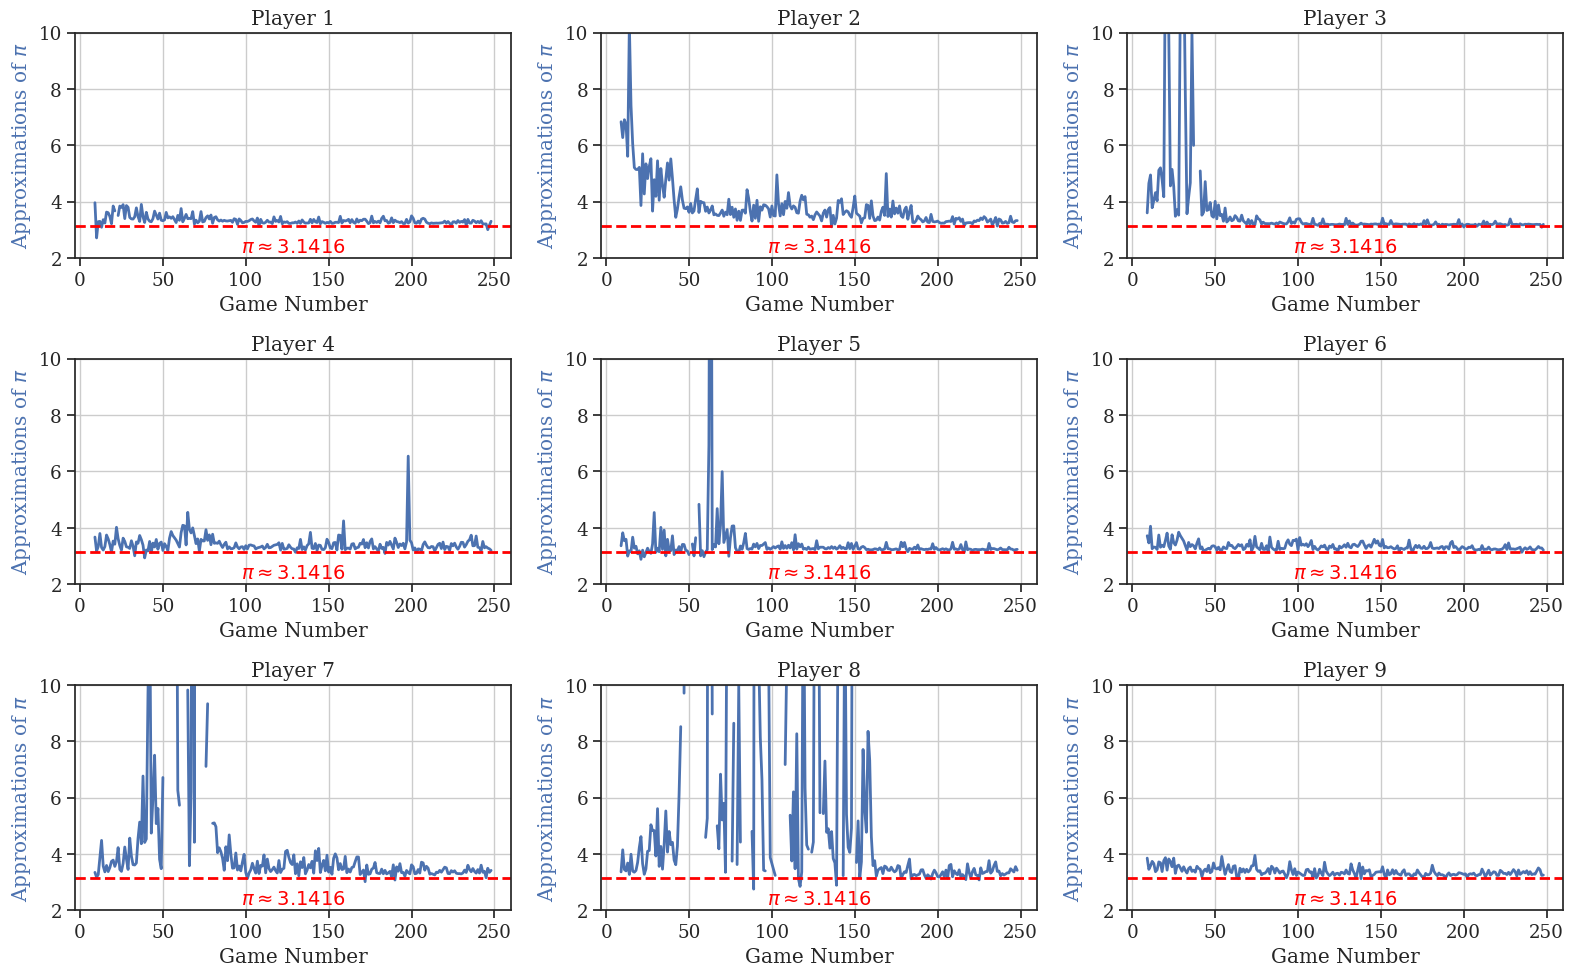

In [84]:
num_rows = 3
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize = (16, 10))

for player in range(1,10):
    fig_ix, fig_iy = int((player-1)/num_rows), (player-1)%num_cols
    ax = axs[fig_ix, fig_iy]
    to_plot = agg_df.loc[(agg_df.pid == player) & (agg_df.game >= 9)]
    # print(to_plot.game)

    ax.plot(to_plot.game, to_plot.pi_per_game, lw = 2)
    ax.axhline(y = 3.1416, color = 'red', ls = "--", lw = 2)
    ax.grid()
    ax.text(0.5, 0.05, r"$\pi \approx 3.1416$", color = 'red', 
         transform = ax.transAxes, fontsize=14, verticalalignment='center', horizontalalignment = 'center',bbox= None)
    ax.set_xlabel("Game Number")
    ax.set_ylabel(r"Approximations of $\pi$", color = "b")
    ax.set_title("Player %i"%player)
    ax.set_ylim([2, 10])
    print(player, fig_ix, fig_iy)

fig.tight_layout()
plt.show()
plt.close()

## Zooming in

1 0 0
2 0 1
3 0 2
4 1 0
5 1 1
6 1 2
7 2 0
8 2 1
9 2 2


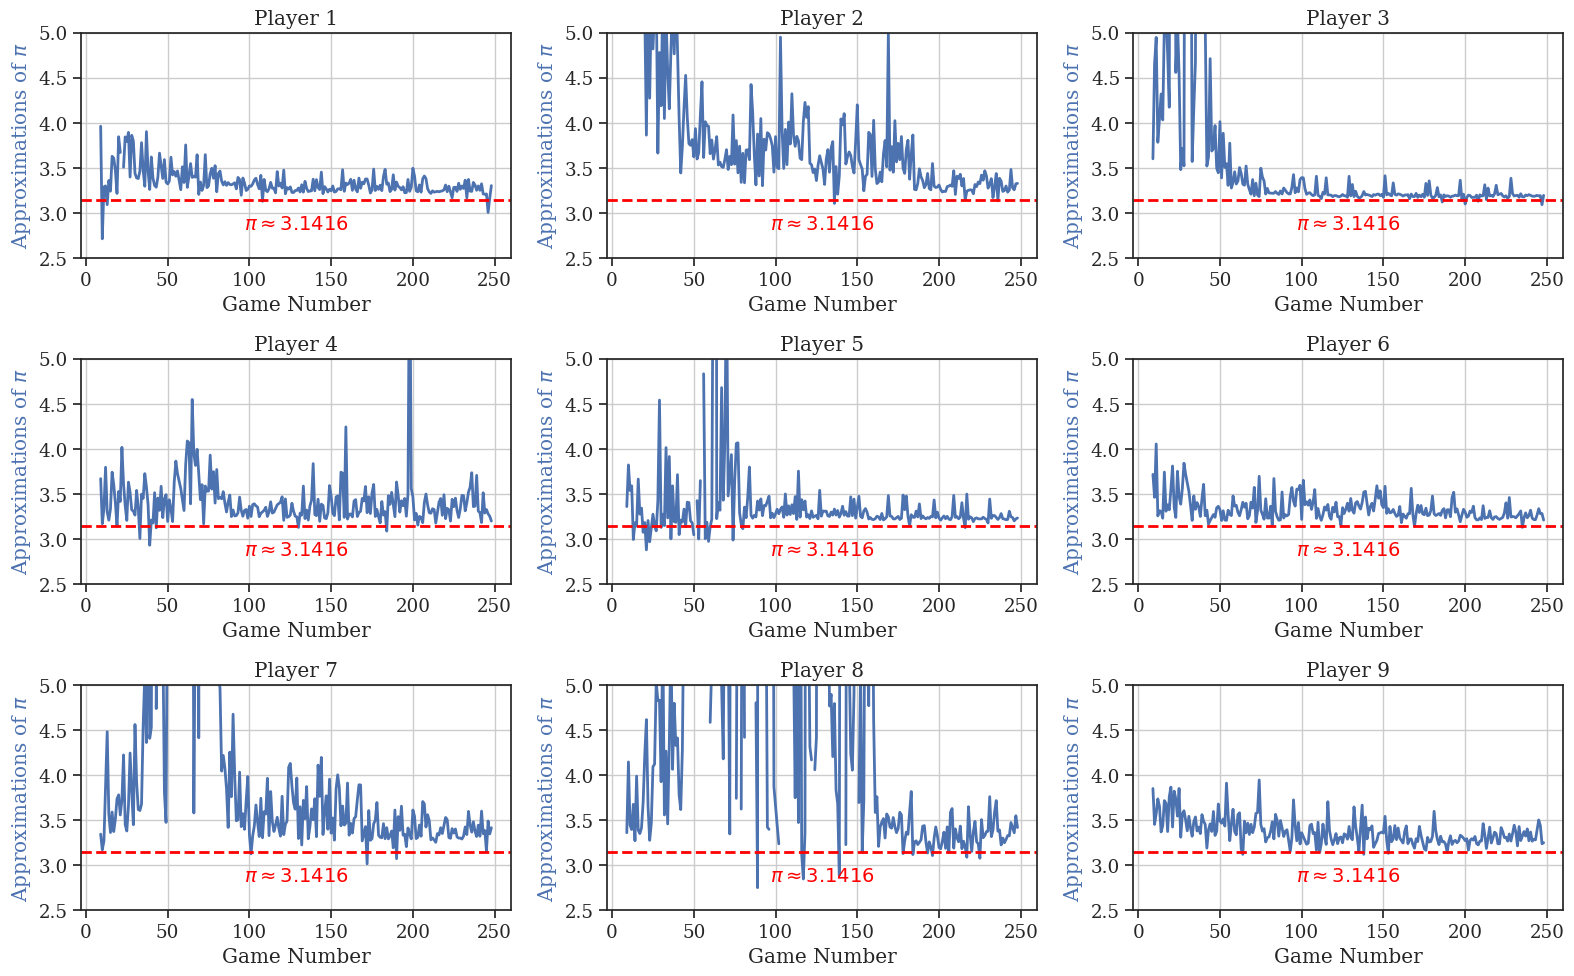

In [85]:
num_rows = 3
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize = (16, 10))
  

   
for player in range(1,10):
    fig_ix, fig_iy = int((player-1)/num_rows), (player-1)%num_cols
    ax = axs[fig_ix, fig_iy]
    to_plot = agg_df.loc[(agg_df.pid == player) & (agg_df.game >= 9)]
    # print(to_plot.game)

    ax.plot(to_plot.game, to_plot.pi_per_game, lw = 2)
    ax.axhline(y = 3.1416, color = 'red', ls = "--", lw = 2)
    ax.grid()
    ax.text(0.5, 0.15, r"$\pi \approx 3.1416$", color = 'red', 
         transform = ax.transAxes, fontsize=14, verticalalignment='center', horizontalalignment = 'center',bbox= None)
    ax.set_xlabel("Game Number")
    ax.set_ylabel(r"Approximations of $\pi$", color = "b")
    ax.set_title("Player %i"%player)
    ax.set_ylim([2.5, 5])
    print(player, fig_ix, fig_iy)

fig.tight_layout()
plt.show()
plt.close()

In [80]:
agg_df.columns

Index(['pid', 'sid', 'game', 'pnts', 'cntrl', 'vlcty', 'speed', 'total',
       'num_ship_hit_by_fortress', 'num_ship_hit_by_mine',
       'num_total_ship_hit', 'num_ship_des', 'num_fortress_kill',
       'num_accidental_vlner_reset', 'num_bonus_avail', 'num_bonus_taken',
       'num_pnts_bonus_taken', 'num_shots_bonus_taken', 'num_friend_available',
       'num_friend_killed', 'num_foe_available', 'num_foe_killed',
       'num_mine_spawned', 'p_friend_killed', 'p_foe_killed', 'num_shot_zero',
       'num_shot_left', 'num_shot_fired', 'num_shot_accu', 'num_bump',
       'num_warp', 'num_thrust', 'avg_thrust_interval', 'avg_thrust_duration',
       'num_right_key', 'avg_right_key_interval', 'avg_right_key_duration',
       'num_left_key', 'avg_left_key_interval', 'avg_left_key_duration',
       'avg_dis', 'avg_dis_rms', 'avg_vel', 'avg_vel_rms', 'total_d_per_cycle',
       'mean_r_per_cycle', 'pi_per_cycle', 'pi_per_game'],
      dtype='object')

25.0 8


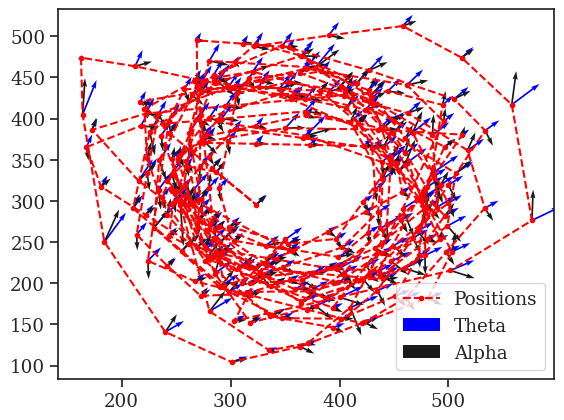

In [108]:
exhibit([[2,200]])

In [115]:
# anim(7)
HTML(anim(7).to_jshtml())


KeyboardInterrupt: 

In [126]:
agg_df_new.pi_per_cycle[2222] + 1 

TypeError: can only concatenate str (not "int") to str